# Group Analysis
*Written by Luke Chang*

In fMRI analysis, we are primarily interested in making inferences about how the brain processes information that is fundamentally similar across all brains even if the person did not directly participate in our study. This requires making inferences about what the magnitude of the population level brain response based on measurements from a few randomly sampled participants who were scanned during our experiment.

In this section, we will talk about how we go from modeling brain responses in each voxel for a single participant to making inferences about our group

For a more in depth overview, I encourage you to watch these short videos by Tor Wager & Martin Lindquist.

**Videos**
- [Group-Level Analysis 1](https://www.youtube.com/watch?v=__cOYPifDWk&list=PLfXA4opIOVrGHncHRxI3Qa5GeCSudwmxM&index=26)
- [Group-Level Analysis 2](https://www.youtube.com/watch?v=-abMLQSjMSI&list=PLfXA4opIOVrGHncHRxI3Qa5GeCSudwmxM&index=27)
- [Group-Level Analysis 3](https://www.youtube.com/watch?v=-yaHTygR9b8&list=PLfXA4opIOVrGHncHRxI3Qa5GeCSudwmxM&index=28)

Let's first import the python modules we will need for this tutorial.

In [2]:
%matplotlib inline

import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltools.stats import regress, zscore
from nltools.data import Brain_Data, Design_Matrix
from nltools.stats import regress 
from nltools.external import glover_hrf
from scipy.stats import ttest_1samp

netid = 'f00275v'
output_dir = '/dartfs/rc/lab/P/Psych60/students_output/%s' % netid
data_dir = '/dartfs/rc/lab/P/Psych60/data/brainomics_data/'

# Hierarchical Data Structure
We can think of the data as being organized into a hierarchical structure. For each brain, we are measuring BOLD activity in hundreds of thousands of cubic voxels sampled at about 0.5Hz (i.e., TR=2s). Our experimental task will have many different trials for each condition (seconds), and these trials may be spread across multiple scanning runs (minutes), or entire scanning sessions (hours). We are ultimately interested in modeling all of these different scales of data to make an inference about the function of a particular region of the brain across the group of participants we sampled, which we would hope will generalize to the broader population.

![HierarchicalStructure.png](../../images/group_analysis/HierarchicalStructure.png)

In the past few notebooks, we have explored how to preprocess the data to reduce noise and enhance our signal and also how we can estimate responses in each voxel to specific conditions within a single participant based on convolving our experimental design with a canonical hemodynamic response function (HRF). Here we will discuss how we combine these brain responses estimated at the first-level in a second-level model to make inferences about the group.

# Modeling Mixed Effects

Most of the statistics we have discussed to this point have assumed that the data we are trying to model are drawn from an identical distribution and that they are independent of each other. For example, each group of participants that complete each version of our experiment are assumed to be random sample of the larger population. However, if there was some type of systematic bias in our sampling strategy, our group level statistics would not necessarily reflect a random draw from the population-level Gaussian distribution. However, as should already be clear from the graphical depiction of the hierarchical structure of our data above, our data are not always independent. For example, we briefly discussed this in the GLM notebook, but voxel responses within the same participant are not necessarily independent as there appears to be a small amount of autocorrelation in the BOLD response. This requires whitening the data to meet the independence assumption. What is clear from the hierarchy is that all of the data measured from one participant are likely to be more similar to each other than another participant. In fact, it is almost always the case that the variance *within* a subject $\sigma_{within}^2$ is almost always smaller than the variance *across* participants $\sigma_{between}^2$. If we combined all of the data from all participants and treated them as if they were independent, we would likely have an inflated view of the group effect (this was historically referred to as a "fixed effects group analysis").

This problem has been elegantly solved in statistics in a class of models called *mixed effects models*. Mixed effects models are an extension of regression that allows data to be structured into groups and coefficients to vary by groups. They are referred to differently in different scientific domains, for example they may be referred to as multilevel, hierarchical, or panel models. The reason that this framework has been found to be useful in many different fields, is that it is particularly well suited for modeling clustered data, such as students in a classroom and also longitudinal or repeated data, such as within subject designs. 

The term "mixed" comes from the fact that these models are composed of both *fixed* and *random* effects. Fixed effects refer to parameters describing the amount of variance that a feature explains of an outcome variable. Fixed factors are often explicitly manipulated in an experiment and can be categorical (e.g., gender) or continuous (e.g., age). We assume that the magnitude of these effects are *fixed* in the population, but that the observed signal strength will vary across sessions and subjects. This variation can be decomposed into different sources of variance, such as: 
    - Measurement or Irreducible Error
    - Response magnitude that varies randomly across subjects.
    - Response magnitude that varies randomly across different elicitations (e.g., trials or sessions).

Modeling these different sources of variance allows us to have a better idea of how generalizable our estimates might be to another participant or trial.

As an example, imagine if we were interested if there were any gender differences between the length of how males and females cut their hair. We might sample a given individual several times over the course of a couple of years to get an accurate measurement of how long they keep their hair. These samples are akin to trials and will give us a way to represent the overall tendency of the length an individual keeps their hair in the form of a distribution. Narrow distributions mean that there is little variability in the length of the hair at each measurement, while wider distributions indicate more variation in the hair length across time. Of course, we are most interested not in the length of how an individual cuts their hair, but rather how many individuals from the same group cut their hair. This requires measuring multiple participants, who will all vary randomly around some population level hair length parameter. We are interested in modeling the true *fixed effect* of what the population parameter is for hair length, and specifically, whether this differs across gender. The variation in measurements within an individual and across individuals will reflect some degree of randomness that we need to account for in order to estimate a parameter that will generalize beyond the participants we measured their hair, but to new participants. 

![MixedEffects.png](../../images/group_analysis/MixedEffects.png)
from Poldrack, Mumford, & Nichols (2011)

In statistics, it is useful to distinguish between the *model* used to describe the data, the *method* of parameter estimation, and the *algorithm* used to obtain them. 

## First Level - Single Subject Model

In fMRI data analysis, we often break analyses into multiple stages. First, we are interested in estimating the parameter (or distribution) of signal in a given region resulting from our experimental manipulation, while simultaneously attempting to control for as much noise and artifacts as possible. This will give us a a single number for each participant of the average length they keep their hair.

At the first level model, for each participant we can define our model as:

$Y_i = X_i\beta + \epsilon_i$, where $i$ is an observation for a single participant and $\epsilon_i \sim \mathcal{N}(0, \sigma_i^2)$

Because participants are independent, it is possible to estimate each participant separately.

To provide a concrete illustration of the different sources of variability in a signal, let's make a quick simulation a hypothetical voxel timeseries.

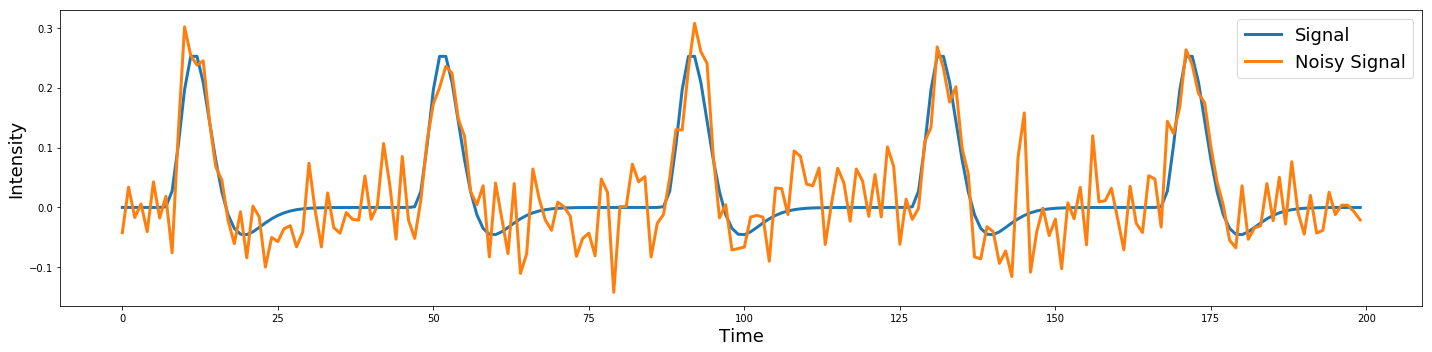

In [88]:
def plot_timeseries(data, linewidth=3, labels=None, axes=True):
    f,a = plt.subplots(figsize=(20,5))
    a.plot(data, linewidth=linewidth)
    a.set_ylabel('Intensity', fontsize=18)
    a.set_xlabel('Time', fontsize=18)
    plt.tight_layout()
    if labels is not None:
        plt.legend(labels, fontsize=18)
    if not axes:
        a.axes.get_xaxis().set_visible(False)
        a.axes.get_yaxis().set_visible(False)
        
def simulate_timeseries(n_tr=200, n_trial=5, amplitude=1, tr=1, sigma=0.05):
    y = np.zeros(n_tr)
    y[np.arange(20, n_tr, int(n_tr/n_trial))] = amplitude

    hrf = glover_hrf(tr, oversampling=1)
    y = np.convolve(y, hrf, mode='same')
    epsilon = sigma*np.random.randn(n_tr)
    y = y + epsilon
    return y

sim1 = simulate_timeseries(sigma=0)
sim2 = simulate_timeseries(sigma=0.05)
plot_timeseries(np.vstack([sim1,sim2]).T, labels=['Signal', 'Noisy Signal'])

Notice that the noise appears to be independent over each TR.

## Second level summary of between group variance

In the second level model, we are interested in relating the subject specific parameters contained in $\beta$ to the population parameters $\beta_g$.  We assume that the first level parameters are randomly sampled from a population of possible regression parameters.

$\beta = X_g\beta_g + \eta$

$\eta \sim \mathcal{N}(0,\,\sigma_g^{2})$ 

Now let's add noise onto the beta parameter to see what happens.

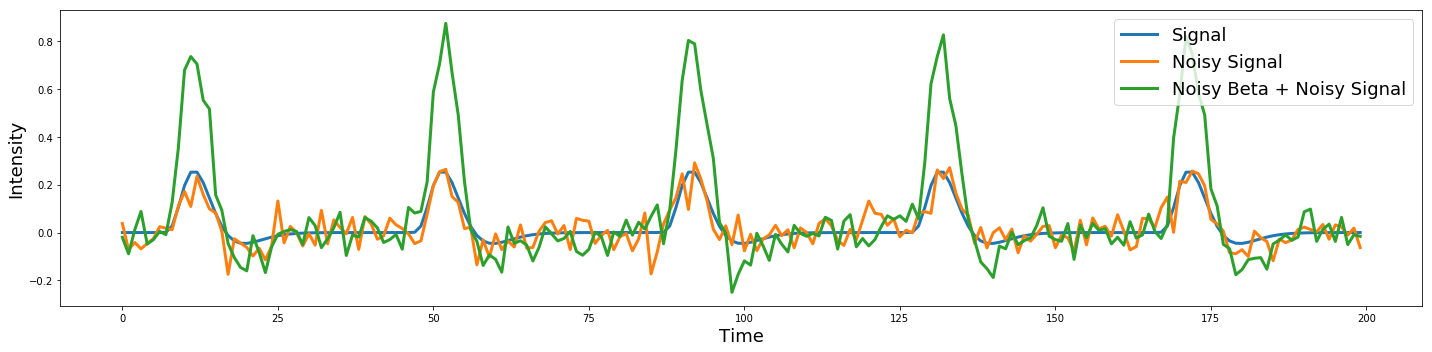

In [101]:
beta = np.abs(np.random.randn())*3
sim1 = simulate_timeseries(sigma=0)
sim2 = simulate_timeseries(sigma=0.05)
sim3 = simulate_timeseries(amplitude=beta, sigma=0.05)
plot_timeseries(np.vstack([sim1,sim2,sim3]).T, labels=['Signal', 'Noisy Signal', 'Noisy Beta + Noisy Signal'])

Try running the above code several times. Can you see how the beta parameter impacts the amplitude of each trial, while the noise appears to be random and uncorrelated with the signal?

Let's try simulating three subjects with a beta drawn from a normal distribution.

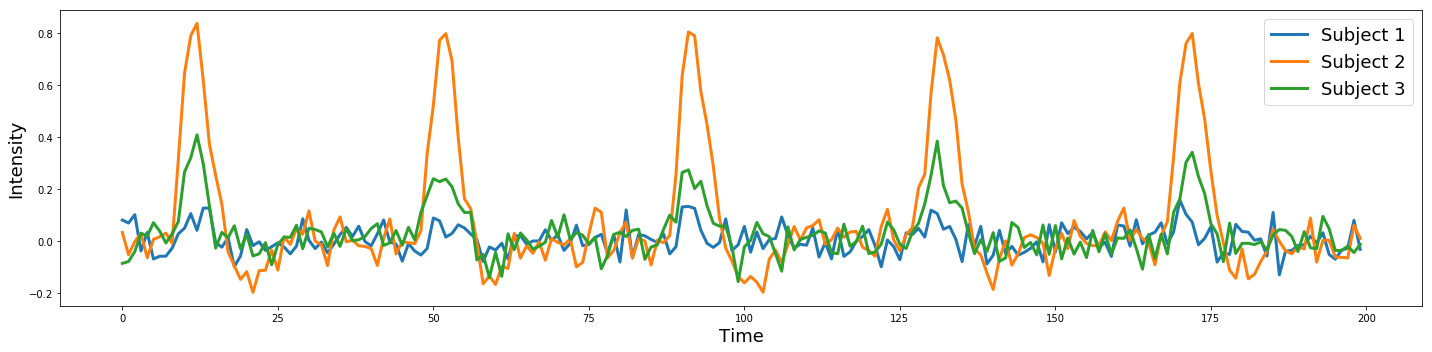

In [109]:
sim1 = simulate_timeseries(amplitude=np.abs(np.random.randn())*2, sigma=0.05)
sim2 = simulate_timeseries(amplitude=np.abs(np.random.randn())*2, sigma=0.05)
sim3 = simulate_timeseries(amplitude=np.abs(np.random.randn())*2, sigma=0.05)
plot_timeseries(np.vstack([sim1, sim2, sim3]).T, labels=['Subject 1', 'Subject 2', 'Subject 3'])

To make an inference if there is a reliable difference within or across groups, we need to model the distribution of the parameters resulting from the first level model using a second level model. For example, if we were solely interested in estimating the average length men keep their hair, we would need to measure hair lengths from lots of different men and the average would be our best guess for any new male sampled from the same population. In our example, we are explicitly interested in the pairwise difference between males and females in hair length. Does the mean hair length for one sex significantly different from the hair length of the other group that is larger than the variations in hair length we observe within each group?

## Mixed Effects Model

In neuroimaging data analysis, there are two main approaches to implementing these different models. Some software packages attempt to use a computatioally efficient approximation and use what is called a two stage approach. First level models are estimated separately for every participant and then the betas from each participants model is combined in a second level model. This is the strategy implemented in SPM and is computationally efficient. However, another approach simultaneously estimates the first and second level models at the same time and often use algorithms that iterate back and forth from the single to the group. The main advantage of this approach over the two-stage approach is that the uncertainty in the parameter estimates at the first-level can be appropriately weighted at the group level. For example, if we had a bad participant with very noisy data, we might not want to weight their estimate when we aggregate everyone's data across the group. The disadvantages is that this procedure is considerably more computationally expensive. This is the approach implemented in FSL, BrainVoyager, and AFNI. In practice, the advantage of the true random effects simultaneous parameter estimation only probably benefits getting more reliable estimates when the sample size is small. In the limit, both methods should converge to the same answer. For a more in depth comparison see this [blog post](http://eshinjolly.com/2019/02/18/rep_measures/) by Eshin Jolly.

A full mixed effects model can be written as, 

$$Y_i = X_i(X_g\beta_g + \eta) +\epsilon_i$$

         or

$$Y \sim \mathcal(XX_g\beta_g, X\sigma_g^2X^T + \sigma^2)$$

![TwoLevelModel.png](../../images/group_analysis/TwoLevelModel.png)

from Poldrack, Mumford, & Nichols (2011)

Let's now try to recover the beta estimates from our 3 simulated subjects.

Text(0, 0.5, 'Estimated Beta')

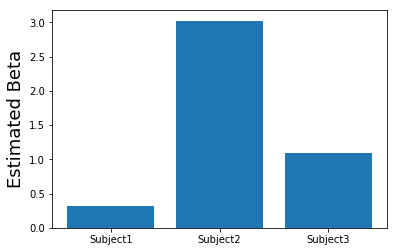

In [126]:
# Create a design matrix with an intercept and predicted response
task = simulate_timeseries(amplitude=1, sigma=0)
X = np.vstack([np.ones(len(task)), task]).T

# Loop over each of the simulated participants and estimate the amplitude of the response.
betas = []
for sub in [sim1, sim2, sim3]:
    beta,_,_,_,_ = regress(X, sub)
    betas.append(beta[1])

# Plot estimated amplitudes for each participant
plt.bar(['Subject1', 'Subject2', 'Subject3'], betas)
plt.ylabel('Estimated Beta', fontsize=18)

What if we simulated lots of participants?  What would the distribution of betas look like?

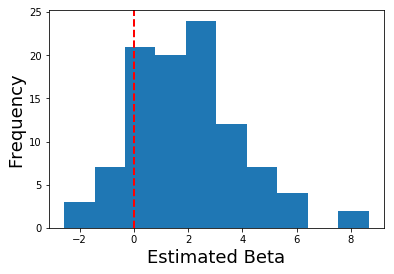

In [158]:
# Create a design matrix with an intercept and predicted response
task = simulate_timeseries(amplitude=1, sigma=0)
X = np.vstack([np.ones(len(task)), task]).T

# Loop over each of the simulated participants and estimate the amplitude of the response.
betas = []
for sub in range(100):
    sim = simulate_timeseries(amplitude=2+np.random.randn()*2, sigma=0.05)
    beta,_,_,_,_ = regress(X, sim)
    betas.append(beta[1])

# Plot distribution of estimated amplitudes for each participant
plt.hist(betas)
plt.ylabel('Frequency', fontsize=18)
plt.xlabel('Estimated Beta', fontsize=18)
plt.axvline(x=0, color='r', linestyle='dashed', linewidth=2)

Now in a second level analysis, we are interested in whether there is a reliable effect across all participants in our sample. In other words, is there a response to our experiment for a specific voxel that is reliably present across our sample of participants?

We can test this hypothesis in our simulation by running a one-sample ttest across the estimated first-level betas at the second level. This allows us to test whether the sample has signal that is reliably different from zero (i.e., the null hypothesis).

In [159]:
ttest_1samp(betas, 0)

Ttest_1sampResult(statistic=9.496118013613062, pvalue=1.3751674242606958e-15)

What did we find?

# Running a Group Analysis

Okay, now let's try and run our own group level analysis with real imaging data using the Pinel Localizer data. I have run a first level model for the first 30 participants using the procedure we used in the single-subject analysis notebook. 

Here is the code I used to complete this for all participants

```
import os
from glob import glob
import pandas as pd
import numpy as np
from nltools.stats import zscore
from nltools.data import Brain_Data, Design_Matrix

data_dir = os.path.join(base_dir, 'data/brainomics_data/')

tr = 2.4
fwhm = 6

def make_motion_covariates(mc):
    z_mc = zscore(mc)
    all_mc = pd.concat([z_mc, z_mc**2, z_mc.diff(), z_mc.diff()**2], axis=1)
    all_mc.fillna(value=0, inplace=True)
    return Design_Matrix(all_mc, sampling_freq=1/tr)

sub = 'S01'
sub_list = [os.path.basename(x) for x in glob(os.path.join(data_dir, 'S*'))]
sub_list = [x for x in sub_list if x != 'S30']
for sub in sub_list:
    print(sub)
    file_name = os.path.join(data_dir, sub ,'preprocessed_fMRI_bold.nii.gz')
    data = Brain_Data(file_name)
    n_tr = len(data)
    spikes = data.find_spikes(global_spike_cutoff=3, diff_spike_cutoff=3)
    mc = pd.read_csv(os.path.join(data_dir, sub ,'realignment_parameters.txt'), sep='\s', header=None)
    mc_cov = make_motion_covariates(mc)
    df = pd.read_csv(os.path.join(data_dir, 'Design_Matrix.csv'))
    dm = Design_Matrix(df, sampling_freq=1/tr)
    dm = dm.loc[:n_tr-1,:]
    dm_conv = dm.convolve()
    dm_conv_filt = dm_conv.add_dct_basis(duration=128)
    dm_conv_filt_poly = dm_conv_filt.add_poly(order=2, include_lower=True)
    dm_conv_filt_poly_cov = dm_conv_filt_poly.append(mc_cov, axis=1).append(Design_Matrix(spikes.iloc[:,1:], sampling_freq=1/tr), axis=1)
    data.X = dm_conv_filt_poly_cov
    stats = data.regress()
    smoothed = stats['beta'].smooth(fwhm=fwhm)
    smoothed.write(os.path.join(data_dir, sub, 'betas_denoised_smoothed_preprocessed_fMRI_bold.nii.gz'))
```

I then wrote out the beta image for each regressor of interest from our design matrix using the following code:

```
df = pd.read_csv(os.path.join(data_dir, 'Design_Matrix.csv'))
file_list = glob(os.path.join(data_dir, '*', 'beta_denoised_smoothed_preprocessed_fMRI_bold.nii.gz'))

for f in file_list:
    sub = os.path.dirname(f).split('/')[-1]
    dat = Brain_Data(f)
    for i in range(df.shape[1]):
        dat[i].write(os.path.join(data_dir, sub, f"{sub}_beta_{df.columns[i]}.nii.gz"))
```

Now, we are ready to run our first group analyses! 

Let's load our design matrix to remind ourselves of the various conditions

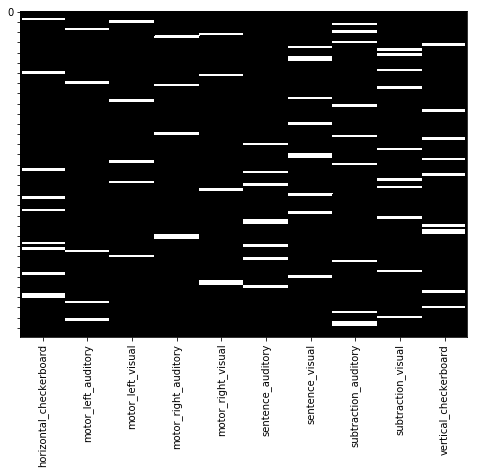

In [17]:
tr = 2.4
df = pd.read_csv(os.path.join(data_dir, 'Design_Matrix.csv'))
dm = Design_Matrix(df, sampling_freq=1/tr)
dm.heatmap()

# One Sample t-test

For our first group analysis, let's try to examine which regions of the brain are consistently activated across participants. We will just load the first regressor in the design matrix - *horizontal_checkerboard*.

We will use the `glob` function to search for all files that contain the name *horizontal_checkerboard* in each subject's folder. We will then sort the list and load all of the files using the `Brain_Data` class.  This will take a little bit to load all of the data into ram.

In [68]:
con1_name = 'horizontal_checkerboard'
con1_file_list = glob.glob(os.path.join(data_dir, '*', f'S*_{con1_name}*nii.gz'))
con1_file_list.sort()
con1_dat = Brain_Data(con1_file_list)

Now that we have the data loaded, we can run quick operations such as, what is the mean activation in each voxel across participants?  Or, what is the standard deviation of the voxel activity across participants?

Notice how we can chain different commands like `.mean()` and `.plot()`.  This makes it easy to quickly manipulate the data similar to how we use tools like pandas.

threshold is ignored for simple axial plots
threshold is ignored for simple axial plots


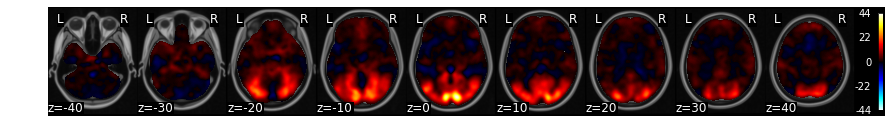

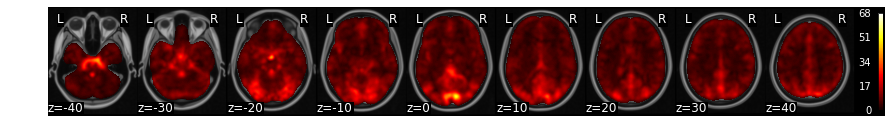

In [74]:
f_mean = con1_dat.mean().plot()

f_std = con1_dat.std().plot()

We can use the `ttest()` method to run a quick t-test across each voxel in the brain. 

In [75]:
con1_stats = con1_dat.ttest()

print(con1_stats.keys())

dict_keys(['t', 'p'])


/Users/lukechang/anaconda3/envs/Psych60_py368/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/lukechang/anaconda3/envs/Psych60_py368/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/lukechang/anaconda3/envs/Psych60_py368/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


This return a dictionary of a map of the t-values and a separate one containing the p-value for each voxel.

For now, let's look at the results of the t-ttest and threshold them to something like t>4.

In [76]:
stats['t'].iplot()

interactive(children=(FloatText(value=0.0, description='Threshold'), HTML(value='Image is 3D', description='Vo…

As you can see we see very clear activation in various parts of visual cortex, which we expected from the visual stimulation.

However, if wanted to test the hypothesis that there are specific areas of early visual cortex (e.g., V1) that process edge orientations, we could run a specific contrast comparing vertical orientations with horizontal orientations.  

Now we need to load the vertical data and create a contrast between horizontal and vertical checkerboards.

Here a contrast is simply [1, -1] and can be achieved by simply subtracting the two images (assuming the subject images are sorted in the same order).

In [77]:
con2_name = 'vertical_checkerboard'
con2_file_list = glob.glob(os.path.join(data_dir, '*', f'S*_{con2_name}*nii.gz'))
con2_file_list.sort()
con2_dat = Brain_Data(con2_file_list)

con1_v_con2 = con1_dat-con2_dat

Again, we will now run a one-sample ttest on the contrast to find regions that are consistently different in viewing horizontal vs vertical checkerboards across participants at the group level.

In [83]:
con1_v_con2_stats = con1_v_con2.ttest()
con1_v_con2_stats['t'].iplot()

/Users/lukechang/anaconda3/envs/Psych60_py368/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/lukechang/anaconda3/envs/Psych60_py368/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/lukechang/anaconda3/envs/Psych60_py368/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


interactive(children=(FloatText(value=0.0, description='Threshold'), HTML(value='Image is 3D', description='Vo…

# Group statistics using design matrices

For these analyses we ran a one-sample t-test to examine the average activation to horizontal checkerboards and the difference between viewing horizontal and vertical checkerboards. This is equivalent to a vector of ones at the second level. The latter analysis is technically a paired-samples t-test.

Do these tests sound familiar?

It turns out that most parametric statistical tests are just special cases of the general linear model.  Here are what the design matrices would look like for various types of statistical tests.


![DesignMatrices.png](../../images/group_analysis/DesignMatrices.png)
from Poldrack, Mumford, & Nichols 2011

In this section, we will explore how we can formulate different types of statistical tests using a regression through simulations.

## One Sample t-test

Just to review, our one sample t-test can also be formulated as a regression, where the beta values for each subject in a voxel are predicted by a vector of ones. This *intercept* only model, computes the mean of $y$. If the mean of $y$ (i.e., the intercept) is consistently shifted away from zero, then we can reject the null hypothesis that the mean of the betas is zero.

$$
\begin{bmatrix}
s_1 \\
s_2 \\
s_3 \\
s_4 \\
s_5 \\
s_6
\end{bmatrix}
\quad
=
\quad
\begin{bmatrix}
1 \\
1 \\
1 \\
1 \\
1 \\
1
\end{bmatrix}
\begin{bmatrix}
\beta_0 
\end{bmatrix}
$$

We can simulate this by generating data from a Gaussian distribution. We will generate two groups, where $y$ reflects equal draws from each of these distributions ${group_1} = \mathcal{N}(10, 2)$ and ${group_2} = \mathcal{N}(5, 2)$. We then regress a vector of ones on $y$.

We report the estimated value of beta and compare it to various summaries of the simulated data. This allows us to see exactly what each parameter in the regression is calculating.

First, let's define a function `run_regression_simulation` to help us generate plots and calculate various ways to summarize the simulation.

In [112]:
def run_regression_simulation(x, y, paired=False):
    '''This Function runs a regression and outputs results'''
    # Estimate Regression
    if not paired:
        b, t, p, df, res = regress(x, y)
        print(f"betas: {b}")
        if x.shape[1] > 1:
            print(f"beta1 + beta2: {b[0] + b[1]}")
            print(f"beta1 - beta2: {b[0] - b[1]}")
            print(f"mean(group1): {np.mean(group1)}")
            print(f"mean(group2): {np.mean(group2)}")
            print(f"mean(group1) - mean(group2): {np.mean(group1)-np.mean(group2)}")
        print(f"mean(y): {np.mean(y)}")
    else:
        beta, t, p, df, res = regress(x, y)
        a = y[x.iloc[:,0]==1]
        b = y[x.iloc[:,0]==-1]
        out = []
        for sub in range(1, X.shape[1]):
            sub_dat = y[X.iloc[:, sub]==1]
            out.append(sub_dat-np.mean(sub_dat))
        avg_sub_mean_diff = np.mean([x[0] for x in out])
        print(f"betas: {b}")
        print(f"contrast beta: {beta[0]}")
        print(f"mean(subject betas): {np.mean(beta[1:])}")
        print(f"mean(y): {np.mean(y)}")
        print(f"mean(a): {a.mean()}")
        print(f"mean(b): {b.mean()}")
        print(f"mean(a-b): {np.mean(a - b)}")
        print(f"sum(a_i-mean(y_i))/n: {avg_sub_mean_diff}")

    # Create Plot
    f,a = plt.subplots(ncols=2, sharey=True)
    sns.heatmap(pd.DataFrame(y), ax=a[0], cbar=False, yticklabels=False, xticklabels=False)
    sns.heatmap(x, ax=a[1], cbar=False, yticklabels=False)
    a[0].set_ylabel('Subject Values', fontsize=18)    
    a[0].set_title('Y')    
    a[1].set_title('X')
    plt.tight_layout()

okay, now let's run the simulation for the one sample t-test.

betas: 7.315928089674621
mean(y): 7.315928089674621


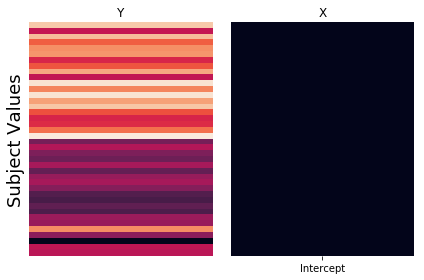

In [113]:
group1_params = {'n':20, 'mean':10, 'sd':2}
group2_params = {'n':20, 'mean':5, 'sd':2}
group1 = group1_params['mean'] + np.random.randn(group1_params['n']) * group1_params['sd']
group2 = group2_params['mean'] + np.random.randn(group2_params['n']) * group2_params['sd']

y = np.hstack([group1, group2])
x = pd.DataFrame({'Intercept':np.ones(len(y))})
    
run_regression_simulation(x, y)
    

The results of this simulation clearly demonstrate that the intercept of the regression is modeling the mean of $y$.

## Independent-Samples T-Test - Dummy Codes

Next, let's explore how we can compute an independent-sample t-test using a regression. There are several different ways to compute this. Each of them provides a different way to test for differences between the means of the two samples.

First, we will explore how dummy codes can be used to test for group differences. We will create a design matrix with an intercept and also a column with a binary regressor indicating group membership. The target group will be ones, and the reference group will be zeros.

$$
\begin{bmatrix}
s_1 \\
s_2 \\
s_3 \\
s_4 \\
s_5 \\
s_6
\end{bmatrix}
\quad
=
\quad
\begin{bmatrix}
1 & 1\\
1 & 1\\
1 & 1\\
1 & 0\\
1 & 0\\
1 & 0
\end{bmatrix}
\begin{bmatrix}
\beta_0 \\
\beta_1
\end{bmatrix}
$$

Let's run another simulation examining what the regression coefficients reflect using this dummy code approach.

betas: [5.19219744 5.11193207]
beta1 + beta2: 10.304129514313178
beta1 - beta2: 0.08026537485257101
mean(group1): 10.304129514313178
mean(group2): 5.192197444582875
mean(group1) - mean(group2): 5.111932069730304
mean(y): 7.748163479448027


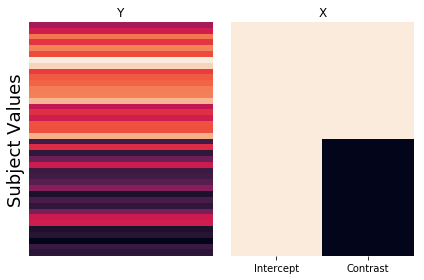

In [114]:
group1_params = {'n':20, 'mean':10, 'sd':2}
group2_params = {'n':20, 'mean':5, 'sd':2}
group1 = group1_params['mean'] + np.random.randn(group1_params['n']) * group1_params['sd']
group2 = group2_params['mean'] + np.random.randn(group2_params['n']) * group2_params['sd']

y = np.hstack([group1, group2])
x = pd.DataFrame({'Intercept':np.ones(len(y)), 'Contrast':np.hstack([np.ones(group1_params['n']), np.zeros(group2_params['n'])])})

run_regression_simulation(x, y)

Can you figure out what the beta estimates are calculating?

The intercept $\beta_0$ is now the mean of the reference group, and the estimate of the dummy code regressor $\beta_1$ indicates the difference of the mean of the target group from the reference group. 

Thus, the mean of the reference group is $\beta_0$ or the intercept, and the mean of the target group is $\beta_1 + \beta_2$. 

## Independent-Samples T-Test - Contrasts

Another way to compare two different groups is by creating a model with an intercept and contrast between the two groups.

$$
\begin{bmatrix}
s_1 \\
s_2 \\
s_3 \\
s_4 \\
s_5 \\
s_6
\end{bmatrix}
\quad
=
\quad
\begin{bmatrix}
1 & 1\\
1 & 1\\
1 & 1\\
1 & -1\\
1 & -1\\
1 & -1
\end{bmatrix}
\begin{bmatrix}
\beta_0 \\
\beta_1
\end{bmatrix}
$$

Let's now run another simulation to see how these beta estimates differ from the dummy code model.


betas: [7.52531063 2.1575329 ]
beta1 + beta2: 9.682843528142556
beta1 - beta2: 5.367777734193592
mean(y): 7.525310631168073
mean(group1): 9.682843528142554
mean(group2): 5.367777734193592
mean(group1) - mean(group2): 4.315065793948961


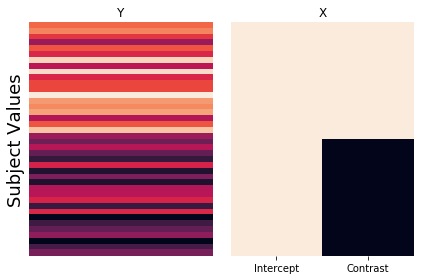

In [12]:
group1_params = {'n':20, 'mean':10, 'sd':2}
group2_params = {'n':20, 'mean':5, 'sd':2}
group1 = group1_params['mean'] + np.random.randn(group1_params['n']) * group1_params['sd']
group2 = group2_params['mean'] + np.random.randn(group2_params['n']) * group2_params['sd']

y = np.hstack([group1, group2])
x = pd.DataFrame({'Intercept':np.ones(len(y)), 'Contrast':np.hstack([np.ones(group1_params['n']), -1*np.ones(group2_params['n'])])})

run_regression_simulation(x, y)

So, just as before, the intercept reflects the mean of $y$. Now can you figure out what $\beta_1$ is calculating?

It is the average distance of each group to the mean. The mean of group 1 is $\beta_0 + \beta_1$ and the mean of group 2 is $\beta_0 - \beta_1$.

Remember that in our earlier discussion of contrast codes, we noted the importance of balanced codes across regressors. What if the group sizes are unbalanced?  Will this effect our results?

To test this, we will double the sample size of group1 and rerun the simulation.

betas: [7.54162736 2.3776784 ]
beta1 + beta2: 9.919305767031998
beta1 - beta2: 5.163948962827957
mean(group1): 9.919305767031997
mean(group2): 5.163948962827955
mean(group1) - mean(group2): 4.755356804204042
mean(y): 8.334186832297316


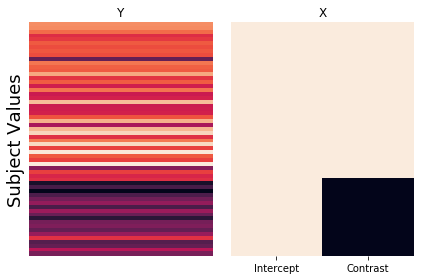

In [115]:
group1_params = {'n':40, 'mean':10, 'sd':2}
group2_params = {'n':20, 'mean':5, 'sd':2}
group1 = group1_params['mean'] + np.random.randn(group1_params['n']) * group1_params['sd']
group2 = group2_params['mean'] + np.random.randn(group2_params['n']) * group2_params['sd']

y = np.hstack([group1, group2])
x = pd.DataFrame({'Intercept':np.ones(len(y)), 'Contrast':np.hstack([np.ones(group1_params['n']), -1*np.ones(group2_params['n'])])})

run_regression_simulation(x, y)

Looks like the beta estimates are identical to the previous simulation. This demonstrates that we *do not* need to adjust the weights of the number of ones and zeros to sum to zero.  This is because the beta is estimating the average distance from the mean, which is invariant to group sizes.

## Independent-Samples T-Test - Group Intercepts

The third way to calculate an independent samples t-test using a regression is to split the intercept into two separate binary regressors with each reflecting the membership of each group. There is no need to include an intercept as it is simply a linear combination of the other two regressors.

$$
\begin{bmatrix}
s_1 \\
s_2 \\
s_3 \\
s_4 \\
s_5 \\
s_6
\end{bmatrix}
\quad
=
\quad
\begin{bmatrix}
1 & 0\\
1 & 0\\
1 & 0\\
0 & 1\\
0 & 1\\
0 & 1
\end{bmatrix}
\begin{bmatrix}
b_0 \\
b_1
\end{bmatrix}
$$


betas: [9.78711484 4.87967575]
beta1 + beta2: 14.666790590832532
beta1 - beta2: 4.907439099129961
mean(y): 7.333395295416267
mean(group1): 9.787114844981248
mean(group2): 4.879675745851285
mean(group1) - mean(group2): 4.907439099129963


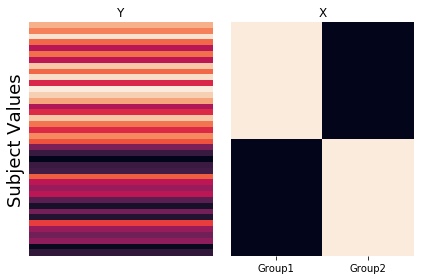

In [6]:
group1_params = {'n':20, 'mean':10, 'sd':2}
group2_params = {'n':20, 'mean':5, 'sd':2}
group1 = group1_params['mean'] + np.random.randn(group1_params['n']) * group1_params['sd']
group2 = group2_params['mean'] + np.random.randn(group2_params['n']) * group2_params['sd']

y = np.hstack([group1, group2])
x = pd.DataFrame({'Group1':np.hstack([np.ones(len(group1)), np.zeros(len(group2))]), 'Group2':np.hstack([np.zeros(len(group1)), np.ones(len(group2))])})

run_regression_simulation(x, y)

This model is obviously separately estimating the means of each group, but how do we know if the difference is significant?  Any ideas?

Just like the single subject regression models, we would need to calculate a contrast, which would simply be $c=[1 -1]$. 

All three of these different approaches will yield identical results when performing a hypothesis test, but each is computing the t-test slightly differently.

## Paired-Samples T-Test

Now let's demonstrate that a paired-samples t-test can also be computed using a regression. Here, we will need to create a long format dataset, in which each subject $s_i$ has two data points (one for each condition $a$ and $b$). One regressor will compute the contrast between condition $a$ and condition $b$. Just like before, we need to account for the mean, but instead of computing a grand mean for all of the data, we will separately model the mean of each participant by adding $n$ more binary regressors where each subject is indicated in each regressor.

$$
\begin{bmatrix}
s_1a \\
s_1b \\
s_2a \\
s_2b \\
s_3a \\
s_3b
\end{bmatrix}
\quad
=
\quad
\begin{bmatrix}
1 & 1 & 0 & 0\\
-1 & 1 & 0 & 0\\
1 & 0 & 1 & 0\\
-1 & 0 & 1 & 0\\
1 & 0 & 0 & 1\\
-1 & 0 & 0 & 1
\end{bmatrix}
\begin{bmatrix}
\beta_0 \\
\beta_1 \\
\beta_2 \\
\beta_3
\end{bmatrix}
$$

This simulation will be slightly more complicated as we will be adding subject level noise to each data point. In this simulation, we will assume that $\epsilon_i = \mathcal{N}(30, 10)$

betas: [20.07157277 31.19543909 40.81026036  3.64231891 29.44153664 33.71159865
 42.96742729 24.22379285 38.61182423 28.18178122 39.30238233 50.26407182
 36.58771528 47.34306937 40.82566265 39.19862603 26.62882288 50.33437057
 39.81456213 54.7994368 ]
contrast beta: 2.318499370670205
mean(subject betas): 38.216312964510266
mean(y): 38.21631296451028
mean(a): 40.53481233518049
mean(b): 35.89781359384007
mean(a-b): 4.636998741340409
sum(a_i-mean(y_i))/n: 2.318499370670204


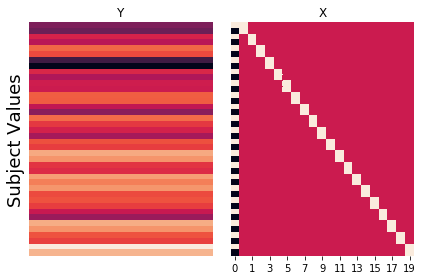

In [116]:
a_params = {'mean':10, 'sd':2}
b_params = {'mean':5, 'sd':2}
sample_params = {'n':20, 'mean':30, 'sd':10}

y = []; x = []; sub_id = [];
for s in range(sample_params['n']):
    sub_mean = sample_params['mean'] + np.random.randn()*sample_params['sd']
    a = sub_mean + a_params['mean'] + np.random.randn() * a_params['sd']
    b = sub_mean + b_params['mean'] + np.random.randn() * b_params['sd']
    y.extend([a,b])
    x.extend([1, -1])
    sub_id.extend([s]*2)
y = np.array(y)

sub_means = pd.DataFrame([sub_id==x for x in np.unique(sub_id)]).T
sub_means = sub_means.replace({True:1,False:0})
X = pd.concat([pd.Series(x), sub_means], axis=1)
    
run_regression_simulation(X, y, paired=True)
    

Okay, now let's try to make sense of all of these numbers. First, we now have $n$ + 1 $\beta$'s. $\beta_0$ corresponds to the between condition contrast. We will call this the *contrast $\beta$*. The rest of the $\beta$'s model each subject's mean. We can see that the means of all of these subject $\beta$'s corresponds to the overall mean of $y$.

Now what is the meaning of the contrast $\beta$?

We can see that it is not the average within subject difference between the two conditions as might be expected given a normal paired-samples t-test.

Instead, just like the independent samples t-test described above, the contrast value reflects the average deviation of a condition from each subject's individual mean.

$$\sum_{i=1}^n{\frac{a_i - mean(y_i)}{n}}$$

where $n$ is the number of subjects, $a$ is the condition being compared to $b$, and the $mean(y_i)$ is the subject's mean.


## Linear and Quadratic contrasts
Hopefully, now you are starting to see that all of the different statistical tests you learned in intro stats (e.g., one-sample t-tests, two-sample t-tests, ANOVAs, and regressions) are really just a special case of the general linear model.

Contrasts allow us to flexibly test many different types of hypotheses within the regression framework. This allows us to test more complicated and precise hypotheses than might be possible than simply turning everything into a binary yes/no question (i.e., one sample t-test), or is condition $a$ greater than condition $b$ (i.e., two sample t-test). We've already explored how contrasts can be used to create independent and paired-samples t-tests in the above simulations. Here we will now provide examples of how to test more sophisticated hypotheses.

Suppose we manipulated the intensity of some type of experimental manipulation across many levels. For example, we increase the working memory load across 4 different levels. We might be interested in identifying regions that monotonically increase as a function of this manipulation. This would be virtually impossible to test using a paired contrast approach (e.g., t-tests, ANOVAs). Instead, we can simply specify a linear contrast by setting the contrast vector to linearly increase. This is as simple as `[0, 1, 2, 3]`. However, remember that contrasts need to sum to zero (except for the one-sample t-test case).  So to make our contrast we can simply subtract the mean - `np.array([0, 1, 2, 3]) - np.mean((np.array([0, 1, 2, 3))`, which becomes $c_{linear} = [-1.5, -0.5,  0.5,  1.5]$.

Regions involved in working memory load might not have a linear increase, but instead might show an inverted u-shaped response, such that the region is not activated at small or high loads, but only at medium loads.  To test this hypothesis, we would need to construct a quadratic contrast $c_{quadratic}=[-1, 1, 1, -1]$.

Let's explore this idea with a simple simulation.

Text(0.5, 1.0, 'Inverted U-Response to WM Load')

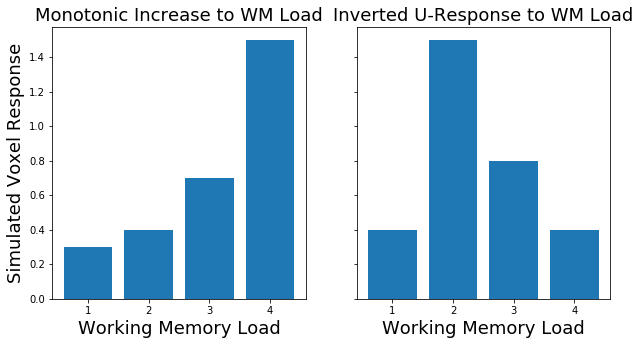

In [156]:
# First let's make up some hypothetical data based on different types of response we might expect to see.
sim1 = np.array([.3, .4, .7, 1.5])
sim2 = np.array([.4, 1.5, .8, .4])

# Now let's plot our simulated data
f,a = plt.subplots(ncols=2, sharey=True, figsize=(10,5))
a[0].bar(x, sim1)
a[1].bar(x, sim2)
a[0].set_ylabel('Simulated Voxel Response', fontsize=18)
a[0].set_xlabel('Working Memory Load', fontsize=18)
a[1].set_xlabel('Working Memory Load', fontsize=18)
a[0].set_title('Monotonic Increase to WM Load', fontsize=18)
a[1].set_title('Inverted U-Response to WM Load', fontsize=18)


See how the data appear to have a linear and quadratic response to working memory load?

Now let's create some contrasts and see how a linear or quadratic contrast might be able to detect these different predicted responses.

Linear Contrast: [-1.5 -0.5  0.5  1.5]
Quadratic Contrast: [-1  1  1 -2]


Text(0.5, 1.0, 'Inverted U-Response to WM Load')

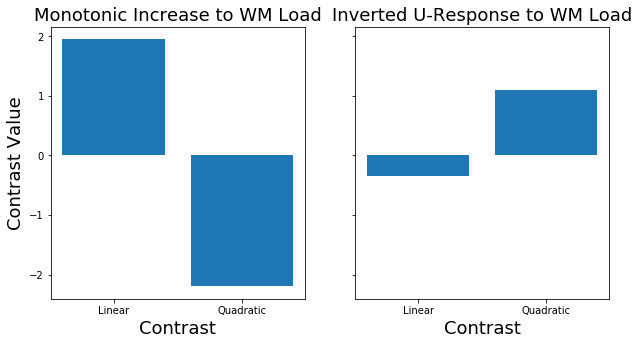

In [157]:
# First let's create some contrast codes.
linear_contrast = np.array([-1.5, -.5, .5, 1.5])
quadratic_contrast = np.array([-1, 1, 1, -2])

print(f'Linear Contrast: {linear_contrast}')
print(f'Quadratic Contrast: {quadratic_contrast}')

# Now let's test our contrasts on each dataset.
sim1_linear = np.dot(sim1, linear_contrast)
sim1_quad = np.dot(sim1, quadratic_contrast)
sim2_linear = np.dot(sim2, linear_contrast)
sim2_quad = np.dot(sim2, quadratic_contrast)

# Now plot the contrast results
f,a = plt.subplots(ncols=2, sharey=True, figsize=(10,5))
a[0].bar(['Linear','Quadratic'], [sim1_linear, sim1_quad])
a[1].bar(['Linear','Quadratic'], [sim2_linear, sim2_quad])
a[0].set_ylabel('Contrast Value', fontsize=18)
a[0].set_xlabel('Contrast', fontsize=18)
a[1].set_xlabel('Contrast', fontsize=18)
a[0].set_title('Monotonic Increase to WM Load', fontsize=18)
a[1].set_title('Inverted U-Response to WM Load', fontsize=18)

As you can see, the linear contrast is sensitive to detecting responses that monotonically increase, while the quadratic contrast is more sensitive to responses that show an inverted u-response. Both of these are also signed, so they could also detect responses in the opposite direction.

If we were to apply this to real brain data, we could now find regions that show a linear or quadratic responses to an experimental manipulation across the whole brain. We would then test the null hypothesis that there is no group effect of a linear or quadratic contrast at the second level. 

Hopefully, this is starting you a sense of the power of contrasts to flexibly test any hypothesis that you can imagine.

# Exercises

## 1. Which regions are more involved with visual compared to auditory sensory processing?
 - Create a contrast to test this hypothesis
 - run a group level t-test
 - plot the results
 - write the file to your output folder.

## 2. Which regions are more involved in processing numbers compared to words?
 - Create a contrast to test this hypothesis
 - run a group level t-test
 - plot the results
 - write the file to your output folder.

## 3. Are there gender differences? 
In this exercise, create a two sample design matrix comparing men and women on arithmetic vs reading.

You will first have to figure out the subjects gender using the using the `metadata.csv` file.

 - Create a contrast to test this hypothesis
 - run a group level t-test
 - plot the results
 - write the file to your output folder.

In [ ]:
meta_data = pd.read_csv(os.path.join(data_dir, 'metadata.csv'), index_col=0)
meta_data.head()